# 1. Distinguish structured from unstructured data

#### Structured data is highly organized and usually fits into rows and columns. The format can be tables, CSV, JSON, or XML documents. Unstructured data lacks a predefined structure/schema and includes free-form text (emails/articles), multimedia (images, audio, video), logs, and sensor streams, which require NLP or other specialized techniques to parse and analyze. Below, we distinguish the two. 

In [191]:
from pathlib import Path
import csv, json
from typing import Dict
import pandas as pd
import numpy as np

In [219]:
class DataClassifier:
    STRUCT_EXTS = {'.csv', '.tsv', '.xlsx', '.xls', '.json', '.parquet'}
    def __init__(self,filepath:str):
        self.path: Path = Path(filepath).expanduser()
        self.features: Dict[str,float] = self._extract_features()

    def _extract_features(self) -> Dict[str,float]:
        ext = self.path.suffix.lower()
        features = {
            'ext_hint': int(ext in self.STRUCT_EXTS),
            'has_header': 0,
            'mean_fields': 0.0,
            'json_struct': 0,
            'pd_struct': 0
        }
        if ext == '.csv':
            csv_feats = self._analyze_csv()
            features.update(csv_feats)
        elif ext == '.json':
            features['json_struct'] = self._analyze_json()
        elif ext in {'.xls', '.xlsx', '.parquet'}:
            features['pd_struct']= self._analyze_table(ext) 
        return features

    def _analyze_csv(self) -> Dict[str,float]:
        try:
            with self.path.open(encoding='utf8', errors = 'ignore') as f:
                lines = [next(f) for _ in range(10)]
            sample = ''.join(lines)
            dia = csv.Sniffer().sniff(sample)
            header = int(csv.Sniffer().has_header(sample))
            counts = [len(line.split(dia.delimiter)) for line in lines]
            mean_f = float(np.mean(counts))
            return{'has_header':header, 'mean_fields': mean_f}
        except (csv.Error, StopIteration, UnicodeDecodeError):
            return{'has_header':0, 'mean_fields':0.0}

    def _analyze_json(self) -> int:
        #Will return 1 if it's a uniform list of dicts or 0 if anything else
        try:
            with self.path.open() as f:
                data=json.load(f)
            if isinstance(data,list) and data and all(isinstance(r,dict)for r in data):
                keys = set(data[0].keys())
                if all(set(r.keys()) == keys for r in data):
                    return 1
        except (json.JSONDecodeError, OSError):
            pass
        return 0

    def _analyze_table(self, ext: str) ->int:
        #Does small read and returns 1 if columns >1
        try:
            if ext in {'.xls', '.xlsx'}:
                df = pd.read_excel(self.path, nrows=10)
            else:
                df = pd.read_parquet(self.path, engine='pyarrow')
            return int((not df.empty) and df.shape[1]>1)
        except (ValueError, OSError):
            return 0
          
    def classify(self):
        #Will return "structured if signals above fire, "unstructured" otherwise
        f = self.features
        if any([f['ext_hint'],f['has_header'] and f['mean_fields']>1, f['json_struct'], f['pd_struct']]):
            return "Structured"
        return "Unstructured"

In [221]:
dc = DataClassifier("/Users/nadineshill/Desktop/titanic_test.csv")
print(dc.features)
print(dc.classify())

{'ext_hint': 1, 'has_header': 1, 'mean_fields': 12.9, 'json_struct': 0, 'pd_struct': 0}
Structured


In [225]:
dc = DataClassifier("/Users/nadineshill/Desktop/words_250000_train.txt")
print(dc.features)
print(dc.classify())

{'ext_hint': 0, 'has_header': 0, 'mean_fields': 0.0, 'json_struct': 0, 'pd_struct': 0}
Unstructured


# 2. Classify primary vs. secondary data

#### Primary data is collected firsthand by the researcher, while secondary data is sourced from somewhere that has already collected the data, such as a CSV, XML, or JSON file. Below, we will compare the two. 

In [143]:
import pandas as pd
import plotly.express as px

#We will define and then classify the sources
sources = [
    {
        'name':'Bank Churn Kaggle CSV',
        'format':'CSV',
        'type':'Secondary'
    },
    {
        'name':'World Bank GDP Excel',
        'format':'Excel',
        'type':'Secondary'
    },
    {
        'name':'REST Countries API JSON',
        'format':'JSON',
        'type':'Secondary'
    },
    {
        'name':'World Bank Country List XML',
        'format':'XML',
        'type':'Secondary'
    },
    {
        'name':'Customer Survey Responses',
        'format':'CSV',
        'type':'Primary'
    }
]

In [145]:
#From the list above, we build a df
df_sources = pd.DataFrame(sources)
print(df_sources)

                          name format       type
0        Bank Churn Kaggle CSV    CSV  Secondary
1         World Bank GDP Excel  Excel  Secondary
2      REST Countries API JSON   JSON  Secondary
3  World Bank Country List XML    XML  Secondary
4    Customer Survey Responses    CSV    Primary


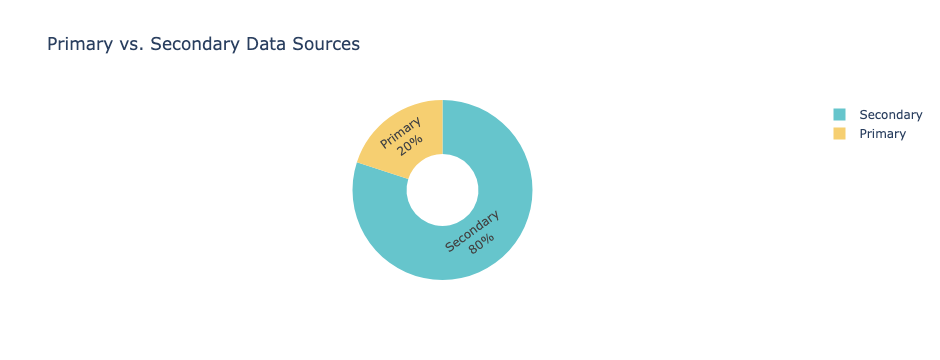

In [147]:
#Now, we will visualize the proportions of primary vs secondary data
data_fig = px.pie(
    df_sources,
    names='type',
    title='Primary vs. Secondary Data Sources',
    hole=0.4,
    color_discrete_sequence=px.colors.qualitative.Pastel
)
data_fig.update_traces(textposition='inside', textinfo='percent+label')
data_fig.show()

# 3. Manipulate public, API, and web scraped data

### 3.1 Manipulating Public Data (from Kaggle API) 

In [7]:
!pip install kaggle

In [8]:
!mkdir ~/.kaggle

mkdir: /Users/nadineshill/.kaggle: File exists


In [10]:
!touch kaggle.json

In [12]:
#Insert your credentials below (username and API key from Kaggle)
api_token = {"username":"YOUR_USERNAME","key":"YOUR_KEY"} 

In [14]:
!ls -la ~/.kaggle

total 8
drwxr-xr-x   3 nadineshill  staff    96 Jul 19 13:03 .
drwxr-x---+ 50 nadineshill  staff  1600 Jul 20 11:49 ..
-rw-------   1 nadineshill  staff    72 Jul 19 13:12 kaggle.json


In [16]:
import json
with open('/Users/nadineshill/.kaggle/kaggle.json','w') as file: 
    json.dump(api_token,file)


In [18]:
!chmod 600 /Users/nadineshill/.kaggle/kaggle.json

In [20]:
!kaggle datasets list

ref                                                        title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
abdulmalik1518/cars-datasets-2025                          Cars Datasets (2025)                                     25987  2025-07-17 21:43:28.493000           1178         36  1.0              
sahilislam007/college-student-placement-factors-dataset    College Student Placement Factors Dataset               110450  2025-07-02 08:33:50.547000           4500         90  1.0              
urvishahir/electric-vehicle-specifications-dataset-2025    Electric Vehicle Specs Dataset (2025)🔋🚗                  16631  2025-06-20 07:14:56.777000           9325        224  1.0              
divyaraj2006/social-media

In [22]:
!kaggle datasets download -d kartiksaini18/churn-bank-customer

Dataset URL: https://www.kaggle.com/datasets/kartiksaini18/churn-bank-customer
License(s): CC0-1.0
churn-bank-customer.zip: Skipping, found more recently modified local copy (use --force to force download)


In [49]:
!unzip churn-bank-customer.zip

Archive:  churn-bank-customer.zip
replace Churn_Modelling.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [151]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

#### Initial exploration and cleaning of the data.

In [153]:
df = pd.read_csv('Churn_Modelling.csv')

In [155]:
df.head(10)

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   
5          6    15574012       Chu          645     Spain    Male   44   
6          7    15592531  Bartlett          822    France    Male   50   
7          8    15656148    Obinna          376   Germany  Female   29   
8          9    15792365        He          501    France    Male   44   
9         10    15592389        H?          684    France    Male   27   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   
5       8  113755.78              2          1               0   
6       7       0.00              2          1               1   
7       4  115046.74              4          1               0   
8       4  142051.07              2          0               1   
9       2  134603.88              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0  
5        149756.71       1  
6         10062.80       0  
7        119346.88       1  
8         74940.50       0  
9         71725.73       0

In [157]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [159]:
dupe_mask = df.duplicated(subset = ['CustomerId'], keep = False)
print(f"{dupe_mask.sum()} duplicate rows found based on CustomerId") 

0 duplicate rows found based on CustomerId


In [161]:
df_clean = df.drop(columns=['Surname', 'CustomerId', 'RowNumber'])

In [163]:
#Ensuring that the data is indeed cleaned by having dropped the columns 'Surname', 'CustomerId', and 'RowNumber'
print(df_clean.shape)
print(df_clean.columns)

(10000, 11)
Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')


#### Some visualizations and EDA

        CreditScore           Age        Tenure        Balance  NumOfProducts  \
count  10000.000000  10000.000000  10000.000000   10000.000000   10000.000000   
mean     650.528800     38.921800      5.012800   76485.889288       1.530200   
std       96.653299     10.487806      2.892174   62397.405202       0.581654   
min      350.000000     18.000000      0.000000       0.000000       1.000000   
25%      584.000000     32.000000      3.000000       0.000000       1.000000   
50%      652.000000     37.000000      5.000000   97198.540000       1.000000   
75%      718.000000     44.000000      7.000000  127644.240000       2.000000   
max      850.000000     92.000000     10.000000  250898.090000       4.000000   

         HasCrCard  IsActiveMember  EstimatedSalary        Exited  
count  10000.00000    10000.000000     10000.000000  10000.000000  
mean       0.70550        0.515100    100090.239881      0.203700  
std        0.45584        0.499797     57510.492818      0.402769 

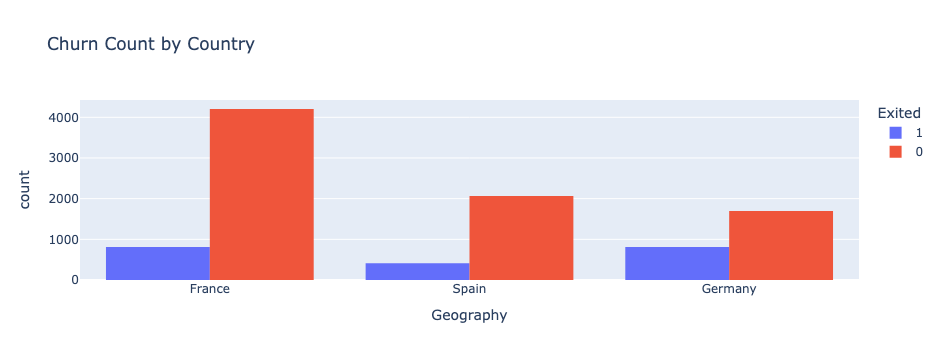

In [166]:
print(df_clean.describe())
print(df['Geography'].value_counts())

#Here we visualize the churn by the country and color whether the customer stayed or churned.
fig = px.histogram(
                   df_clean, x = 'Geography', color = 'Exited', barmode = 'group',
                   title = 'Churn Count by Country'
                   )
fig.show()

In [72]:
df_clean['Balance'].mean()

76485.889288

In [74]:
df_clean['EstimatedSalary'].mean()

100090.239881

In [76]:
df_clean[['Balance','EstimatedSalary']].corr()

Balance  EstimatedSalary
Balance          1.000000         0.012797
EstimatedSalary  0.012797         1.000000

In [78]:
geography_group = df_clean.groupby('Geography')

In [80]:
geography_group.sum()['Balance']

Geography
France     3.113325e+08
Germany    3.004029e+08
Spain      1.531236e+08
Name: Balance, dtype: float64

In [87]:
df_geo_means = df_clean.groupby('Geography')[['Balance', 'EstimatedSalary']].mean().reset_index()

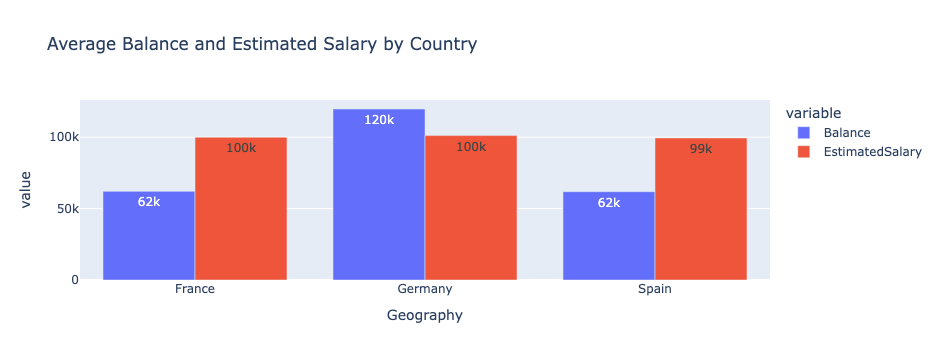

In [89]:
geo_means_fig = px.bar(
                       df_geo_means, x = 'Geography', y =['Balance','EstimatedSalary'],
                       barmode='group',
                       title = 'Average Balance and Estimated Salary by Country',
                       text_auto='.2s'
                      )
geo_means_fig.show()

In [95]:
#Exploring the correlation between balance and estimated salary
corr = df_clean[['Balance','EstimatedSalary']].corr()

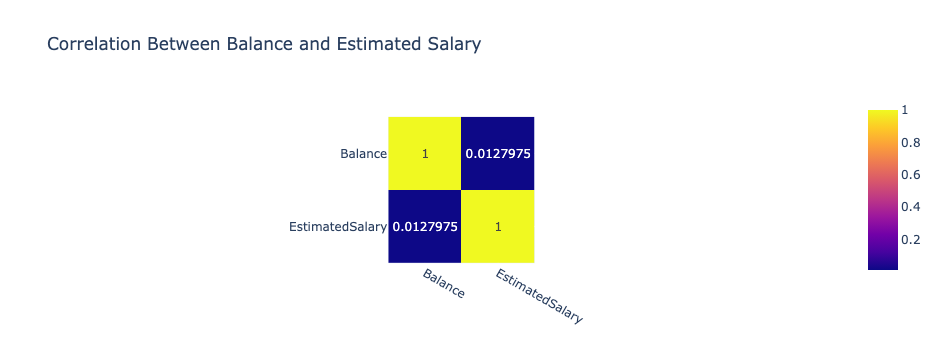

In [99]:
#Visualizing this correlation
corr_fig_salary = px.imshow(
    corr,
    text_auto=True,
    title="Correlation Between Balance and Estimated Salary"
)
corr_fig_salary.show()

In [105]:
#Moving on to encoding categorical features (geography and gender)
df_encoded = pd.get_dummies(df_clean,
                            columns = ['Geography' , 'Gender'], drop_first= True
                           )

#Binning age into stages
age_binner = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy = 'quantile')
df_clean['age_group'] = age_binner.fit_transform(df_clean[['Age']]).astype(int)
df_clean['age_group'] = df_clean['age_group'].map({0:'Youth', 1:'Middle_Aged', 2:'Senior'})


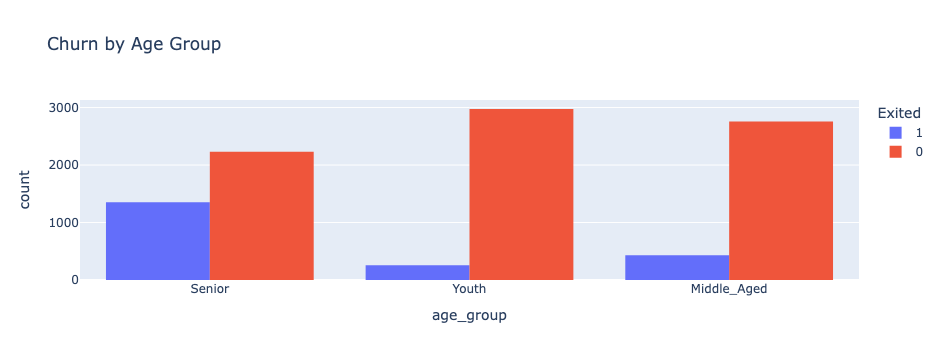

In [107]:
encoded_df_fig = px.histogram(
                              df_clean, x = 'age_group', color = 'Exited',
                              barmode ='group', title = 'Churn by Age Group'
                             )
encoded_df_fig.show()

In [113]:
#Exploring some ratio/interaction features such as balance, products per year of tenure and age adjusted tenure
df_clean['bal_to_salary'] = df_clean['Balance']/ (df_clean['EstimatedSalary']+1)
df_clean['annual_prod'] = df['NumOfProducts']/ (df_clean['Tenure']+1)
df_clean['tenure_ratio']=df['Tenure']/df['Age']

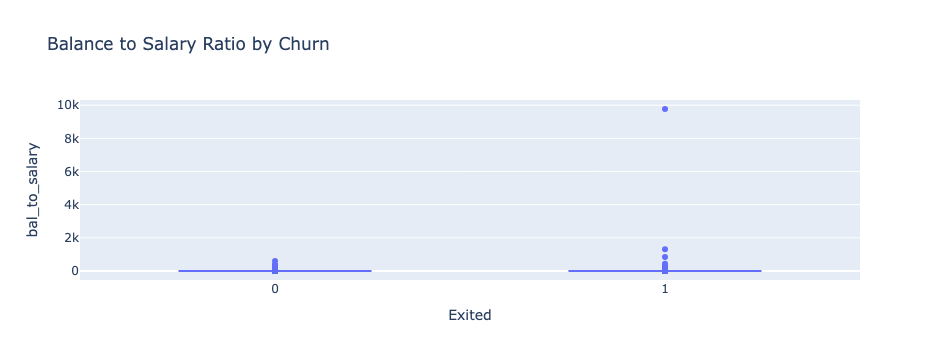

In [115]:
#Now visualizing the balance to salary vs churn
bal_sal_churn_fig = px.box(
                           df_clean, 
                           x='Exited', y='bal_to_salary',title = 'Balance to Salary Ratio by Churn'
                          )
bal_sal_churn_fig.show()

#### Distributional transformations

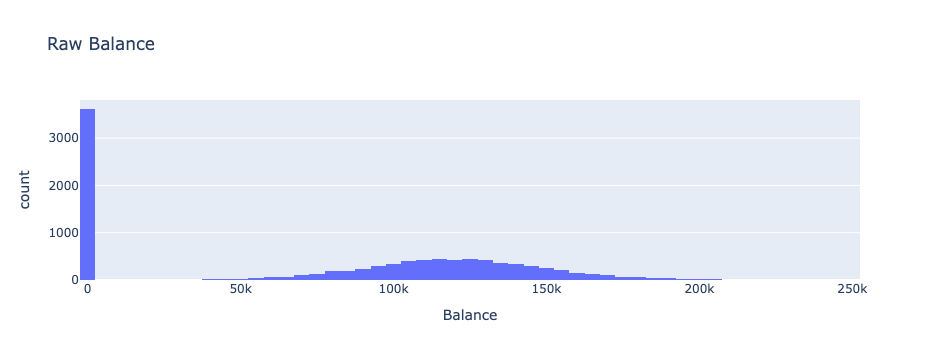

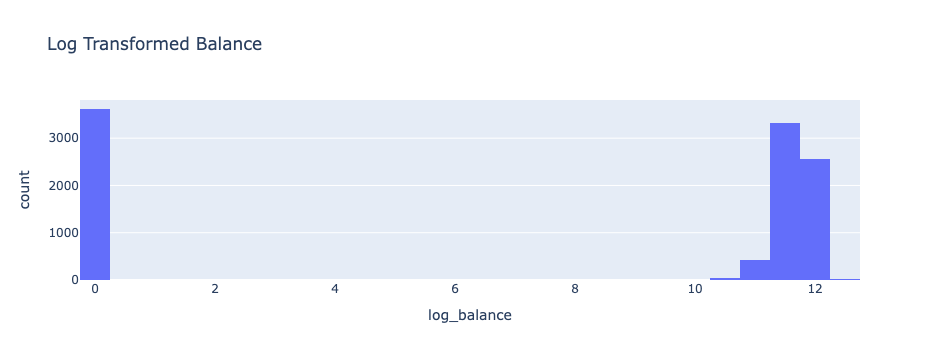

In [140]:
#Log transformation of financial columns
df_clean['log_balance'] = np.log1p(df_clean['Balance'])
df_clean['log_est_salary'] = np.log1p(df_clean['EstimatedSalary'])

#Clipping extreme balances to tame skew and outliers
upper = df_clean['Balance'].quantile(0.99)
df_clean['cap_balance'] = df_clean['Balance'].clip(upper=upper)

#Visualization of before and after the log transformation
raw_fig1 = px.histogram(df_clean, x='Balance', title = 'Raw Balance')
log_transf_fig = px.histogram(df_clean, x='log_balance', title = 'Log Transformed Balance')
raw_fig1.show()
log_transf_fig.show()

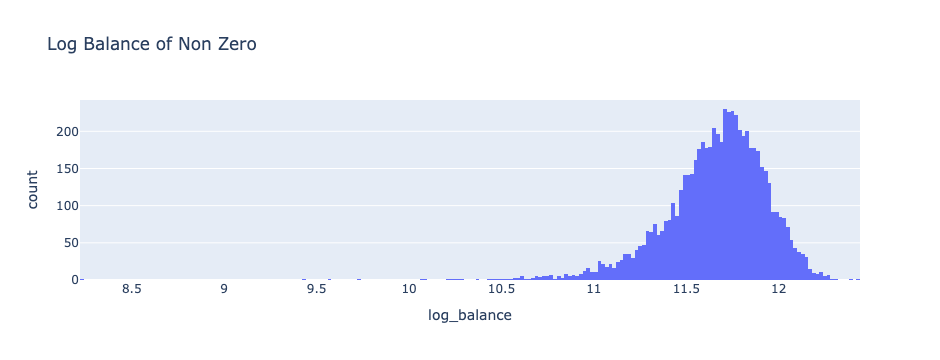

In [166]:
#Visualization without the zero outlier
non_zero = df_clean[df_clean['Balance']>0].assign(log_bal=np.log1p(df_clean['Balance']))
non_zero_log_fig = px.histogram(non_zero, x='log_balance',title ='Log Balance of Non Zero')
non_zero_log_fig.show()

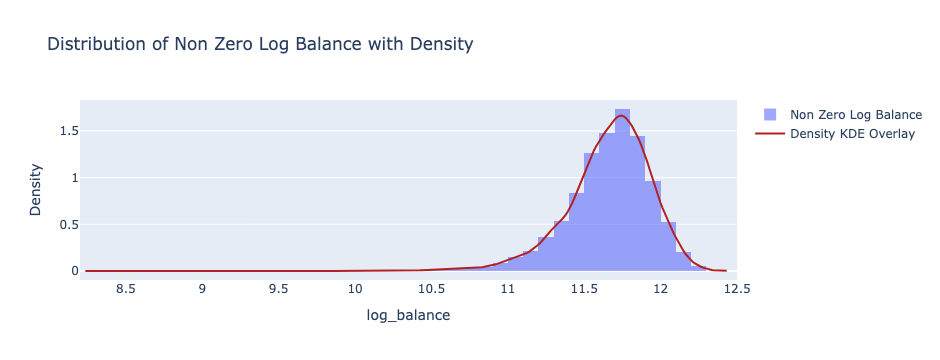

In [174]:
vals = df_clean.loc[df_clean['Balance'] > 0, 'log_balance']

#Compututing KDE
kde = gaussian_kde(vals)
x_grid = np.linspace(vals.min(), vals.max(), 300)
y_kde  = kde(x_grid)

kde_fig = go.Figure()

#Histogram (density) of non‑zero log balance
kde_fig.add_trace(go.Histogram(x=vals,histnorm='probability density',nbinsx=50,opacity=0.6,
    name='Non Zero Log Balance'
))

# KDE line overlay
kde_fig.add_trace(go.Scatter(x=x_grid, y=y_kde,mode='lines',line=dict(width=2, color='firebrick'),
                     name='Density KDE Overlay'
))

kde_fig.update_layout(
    title="Distribution of Non Zero Log Balance with Density",
    xaxis_title="log_balance",
    yaxis_title="Density"
)

kde_fig.show()

#### Dimensionality reduction and selection

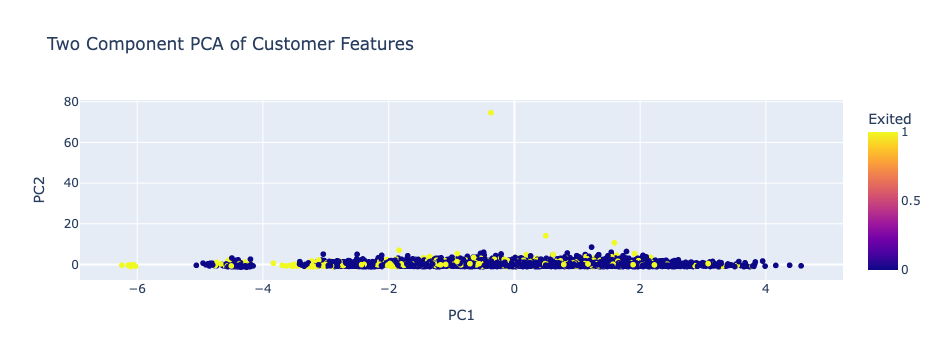

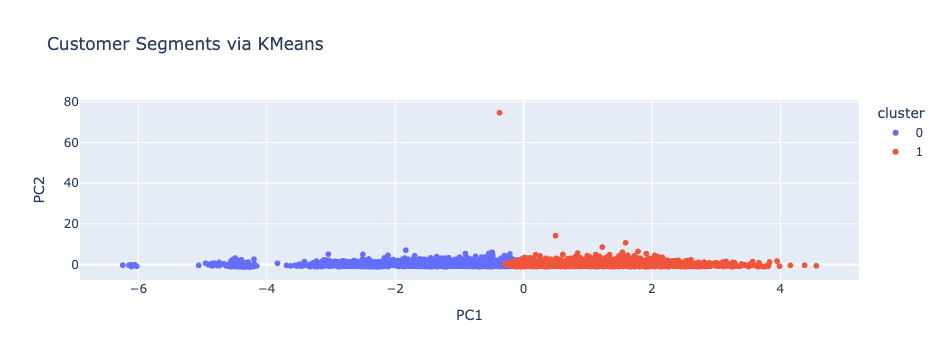

In [216]:
#Defining numeric columns
num_columns = ['CreditScore','Age','log_balance','log_est_salary','Tenure','bal_to_salary','annual_prod','tenure_ratio']
scaler = StandardScaler()
scaled = scaler.fit_transform(df_clean[num_columns])


#PCA
pca=PCA(n_components=2, random_state=42)
pc_vals = pca.fit_transform(scaled)
pc_df_clean = pd.DataFrame(pc_vals, columns=['PC1','PC2']
)
pc_df_clean['Exited'] = df_clean['Exited']

#PCA Plot
pc_fig = px.scatter(pc_df_clean, x='PC1', y='PC2', color='Exited',title='Two Component PCA of Customer Features')
pc_fig.show()

#KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(scaled)

#Lables
df_clean['cluster']      = labels
pc_df_clean['cluster']   = labels.astype(str)

customer_km_fig = px.scatter(
    pc_df_clean,
    x='PC1', y='PC2',
    color='cluster',
    title='Customer Segments via KMeans'
)
customer_km_fig.show()


Silhouette (k=2): 0.22589757966023463


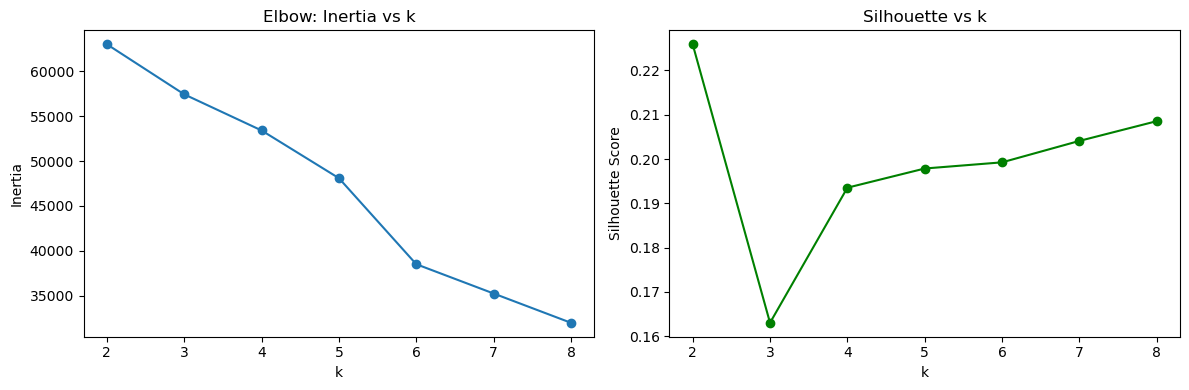

In [220]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

#Previously, my clusters were k=4, which led to a lower silhouette score. So I ran the elbow and silhouette to inspect and choose a better k. 
sil = silhouette_score(scaled, df_clean['cluster'])
print('Silhouette (k=2):', sil)

#Elbow and silhouette
inertias, sils = [], []
ks = range(2, 9)
for k in ks:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(scaled)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(scaled, labels))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(ks, inertias, marker='o')
plt.title('Elbow: Inertia vs k')
plt.xlabel('k'); plt.ylabel('Inertia')

plt.subplot(1,2,2)
plt.plot(ks, sils, marker='o', color='green')
plt.title('Silhouette vs k')
plt.xlabel('k'); plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

### 3.2 API Data Manipulation

#### Here, we will be using a weather API and Denver coordinates to obtain and merge weather data.

In [181]:
import requests
import pandas as pd
import numpy as np

#Using Denver coordinates
url = (
    "https://api.open-meteo.com/v1/forecast?"
    "latitude=39.7392&longitude=-104.9903&hourly=temperature_2m,relative_humidity_2m"
)
resp = requests.get(url)
resp.raise_for_status()
data = resp.json()

#Here, we build an hourly DF. Temp will be in C
weather_df = pd.DataFrame({
    'time': pd.to_datetime(data['hourly']['time']),
    'temperature_c': data['hourly']['temperature_2m'],
    'humidity_pct': data['hourly']['relative_humidity_2m']
})
print(weather_df.head)

<bound method NDFrame.head of                    time  temperature_c  humidity_pct
0   2025-07-21 00:00:00           32.5            18
1   2025-07-21 01:00:00           29.7            24
2   2025-07-21 02:00:00           28.4            21
3   2025-07-21 03:00:00           24.7            31
4   2025-07-21 04:00:00           23.8            33
..                  ...            ...           ...
163 2025-07-27 19:00:00           36.2             8
164 2025-07-27 20:00:00           37.2             8
165 2025-07-27 21:00:00           37.4             8
166 2025-07-27 22:00:00           36.7             9
167 2025-07-27 23:00:00           35.2            12

[168 rows x 3 columns]>


In [203]:
today = pd.to_datetime('2025-07-21').date()
today_df = weather_df[weather_df['time'].dt.date == today].copy()


daily_weather = today_df.assign(date=today_df['time'].dt.date).groupby('date', as_index=False).agg(
    avg_temp_c=('temperature_c','mean'),
    avg_humidity=('humidity_pct','mean')
)

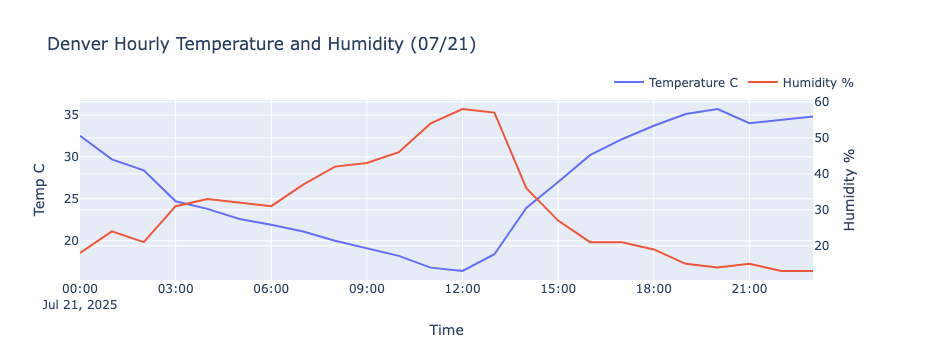

         date  avg_temp_c  avg_humidity
0  2025-07-21     26.4375     30.041667


In [195]:
#Now, we plot the temperature throughout the day 07/21
weather_fig = make_subplots(specs=[[{'secondary_y': True}]])
weather_fig.add_trace(go.Scatter(x=today_df['time'], y=today_df['temperature_c'],
                         name='Temperature C'), secondary_y=False)
weather_fig.add_trace(go.Scatter(x=today_df['time'], y=today_df['humidity_pct'],
                         name='Humidity %'), secondary_y=True)
weather_fig.update_layout(title='Denver Hourly Temperature and Humidity (07/21)',
                  xaxis_title='Time',
                  legend=dict(orientation='h', yanchor="bottom", y=1.02, xanchor='right', x=1))
weather_fig.update_yaxes(title_text='Temp C', secondary_y=False)
weather_fig.update_yaxes(title_text='Humidity %', secondary_y=True)
weather_fig.show()

print(daily_weather)

<Axes: title={'center': 'Temperature Distribution'}, ylabel='Frequency'>

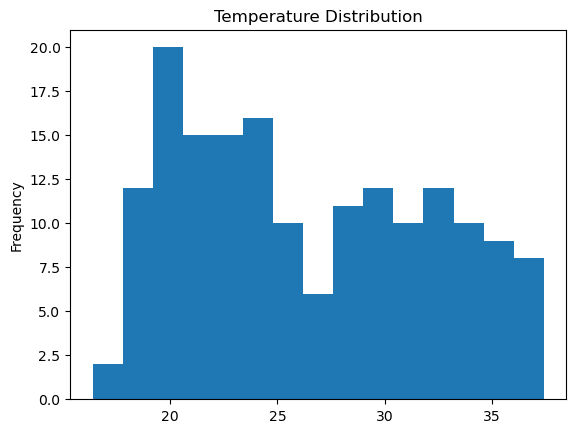

In [197]:
#Next, we will look at the temperature distribution
weather_df['temperature_c'].plot(kind='hist', bins=15, title='Temperature Distribution')

In [201]:
merged.groupby('avg_humidity')['avg_temp_c'].mean()

avg_humidity
30.041667    26.4375
Name: avg_temp_c, dtype: float64

In [199]:
weather_df[['temperature_c','humidity_pct']].corr()

temperature_c  humidity_pct
temperature_c       1.000000     -0.923948
humidity_pct       -0.923948      1.000000

### 3.3 Web Scrapping Data Manipulation

#### In this section we scrape a book website. 

In [25]:
import requests 
from bs4 import BeautifulSoup
import pandas as pd

#Getting the webpage content
url = "http://books.toscrape.com/catalogue/page-1.html"
response = requests.get(url)
response.raise_for_status()

#Parsing the HTML
soup = BeautifulSoup(response.text, 'html.parser')

#Data extraction
books = soup.select('.product_pod')
data = []

for book in books:
    title = book.h3.a['title']
    price_text = book.select_one('.price_color').get_text(strip=True)
    #Only obtaining the numeric part without currency
    match = re.search(r'\d+\.\d+', price_text)
    price = float(match.group()) if match else None
    rating = book.p['class'][1] 
    in_stock = book.select_one('.instock.availability').text.strip()
    data.append({'title': title, 'price': price, 'rating': rating, 'in stock': in_stock})

#Getting Df
web_df = pd.DataFrame(data)
print(df.head())

                                   title  price rating  in stock
0                   A Light in the Attic  51.77  Three  In stock
1                     Tipping the Velvet  53.74    One  In stock
2                             Soumission  50.10    One  In stock
3                          Sharp Objects  47.82   Four  In stock
4  Sapiens: A Brief History of Humankind  54.23   Five  In stock


In [31]:
#Some cleaning of the ratings
ratings_map = {'One':1,'Two':2,'Three':3,'Four':4,'Five':5}
web_df['rating_num'] = web_df['rating'].map(ratings_map)

#Now, getting some stats
web_df.select_dtypes(include='number').describe()
df['rating'].value_counts()

rating
One      6
Four     4
Five     4
Three    3
Two      3
Name: count, dtype: int64

In [33]:
#Sorting and filtering through the books with five star ratings that are cheaper than 50
web_df.sort_values('price', ascending=False).head()

# Books with 5-star rating cheaper than £50
web_df[(web_df['rating'] == 'Five') & (df['price'] < 50)]


title  price rating  in stock  rating_num
12                Set Me Free  17.46   Five  In stock           5
14  Rip it Up and Start Again  35.02   Five  In stock           5

In [39]:
#Exploring averages per rating
df.groupby('rating')['price'].mean()

rating
Five     39.750000
Four     31.105000
One      40.018333
Three    42.316667
Two      36.830000
Name: price, dtype: float64

In [49]:
#Exploring some text search for titles containing the word 'History'
web_df[web_df['title'].str.contains('History', case=False)]

title  price rating  in stock  rating_num
4  Sapiens: A Brief History of Humankind  54.23   Five  In stock           5

In [51]:
#Now looking for titles with the word 'Attic'
web_df[web_df['title'].str.contains('Attic', case=False)]

title  price rating  in stock  rating_num
0  A Light in the Attic  51.77  Three  In stock           3

Text(0.5, 1.0, 'Price Distribution')

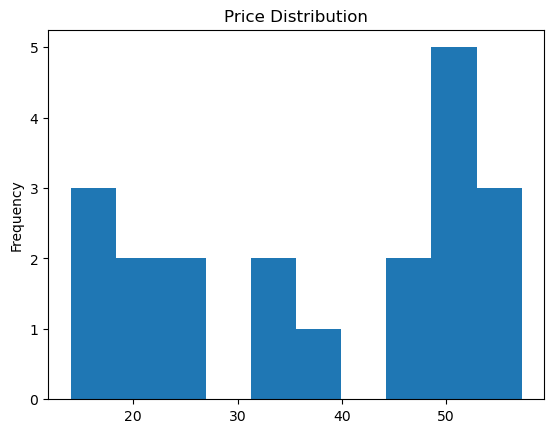

In [60]:
#Visualization with matplotlib

import matplotlib.pyplot as plt

#Visualizing price distribution
web_df['price'].plot(kind='hist')
plt.title('Price Distribution')

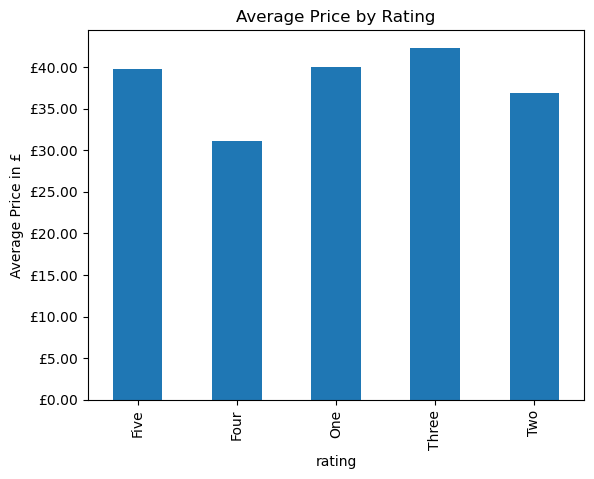

In [76]:
#Visualizing average price by rating
from matplotlib.ticker import FuncFormatter

pl = df.groupby('rating')['price'].mean().plot(kind='bar')
pl.set_title('Average Price by Rating')
pl.set_ylabel('Average Price in £')
pl.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f'£{v:.2f}'))

In [78]:
#Here, we export our data
web_df.to_csv("books_page1.csv", index=False)

##### For this webpage, there are no books that are "not in stock" however, if they did exist we could normalize "in stock"

# 4. Investigate observations by reading data from various formats (CSV, Excel, JSON)

#### Here, I am investigating observations by reading CSV, Excel, JSON, and XML. 

In [236]:
#First, we'll explore how customer-level churn and average balances that vary by country, and examine their relationship to each country's
#GDP per capita.
#To achieve this, we will merge two sources which is a CSV churn modeling dataset and an Excel dataset of each country's GDP per capita. 

df_churn = pd.read_csv('Churn_Modelling.csv')
#Now, we will examine only relevant columns. 
df_churn = df_churn[['CustomerId','Geography','Exited','Balance','EstimatedSalary']]


df_gdp = pd.read_excel('/Users/nadineshill/Desktop/API_NY.GDP.PCAP.CD_DS2_en_excel_v2_38334.xls',
    sheet_name='Data',
    skiprows=3)
df_gdp = (df_gdp[['Country Name','2020']].rename(columns={'Country Name':'Geography','2020':'GDP_per_Capita'})
      .dropna(subset=['GDP_per_Capita']))

In [248]:
#This step indicated which countries in my churn file had matching GDP records and which did not. 
#If there are any left_only rows it would be flagged as a naming mismatch of missing entry which would 
#need to be cleaned. 
df_csv_xls = df_churn.merge(df_gdp, on='Geography', how='left', indicator=True)
print(df_csv_xls['_merge'].value_counts())

_merge
both          10000
left_only         0
right_only        0
Name: count, dtype: int64


In [270]:
#Here, the percentage of customers who churned, their average balance and salary, along with
#that country's GDP per capita from Excel is aggregated. 
summary = (
    df_csv_xls
      .groupby('Geography', as_index=False)
      .agg(
         churn_rate    = ('Exited', 'mean'),
         avg_balance   = ('Balance', 'mean'),
         avg_salary    = ('EstimatedSalary', 'mean'),
         gdp_per_capita= ('GDP_per_Capita', 'mean')
      )
)

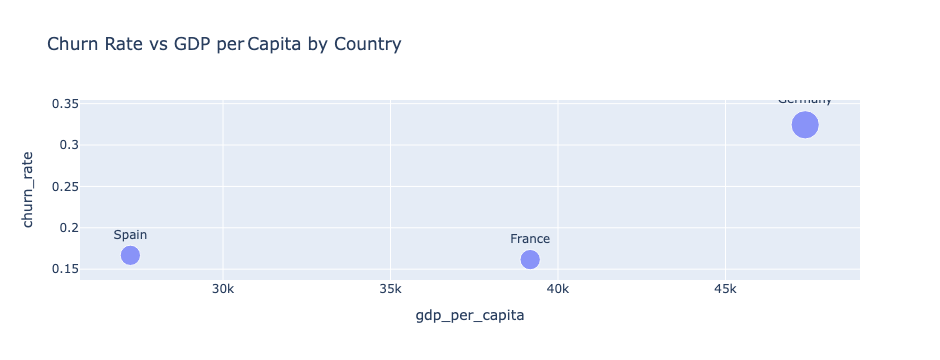

GDP Churn correlation: 0.79


In [298]:
agg_fig = px.scatter(
    summary,
    x='gdp_per_capita',
    y='churn_rate',
    size='avg_balance',     
    hover_data=['avg_salary'],
    text='Geography',
    title='Churn Rate vs GDP per Capita by Country'
)
agg_fig.update_traces(textposition='top center')
agg_fig.show()

# and compute correlation
corr = summary[['gdp_per_capita','churn_rate']].corr().iloc[0,1]
print(f'GDP Churn correlation: {corr:.2f}')

#This shows how our correlation is 0.79, meaning the wealthiest country (Germany) has the highest churn rate.

In [133]:
#Now, we will explore and merge some JSON and XML data. The JSON is countries and their codes, and the XML is population.
#We merge the two to obtain a dataset of the country's population and its codes.
import requests
import pandas as pd
import io
import matplotlib.pyplot as plt

#Here, we obtain some JSON data and inspect the structure 
json_url = "http://api.worldbank.org/v2/country"
params   = {'per_page': 300, 'format': 'json'}

#Here, we check the status, and it will fail if it's a bad response
resp = requests.get(json_url, params=params)
resp.raise_for_status()                    

payload = resp.json()                       
metadata, countries = payload             

print(f'HTTP status: {resp.status_code}')
print(f'Countries: {len(countries)}')
print(f'Top level types: {[type(x) for x in payload]}')

HTTP status: 200
Countries: 296
Top level types: [<class 'dict'>, <class 'list'>]


In [134]:
countries = payload[1]

#Now, normalizing the data, subsetting them into relevant columns, and renaming
df_json = (pd.json_normalize(countries)
             [['name','id','iso2Code','region.value']]
             .rename(columns={
                 'name':'Geography',
                 'id':'ISO3',
                 'iso2Code':'ISO2',
                 'region.value':'Region_JSON'
             }))

In [137]:
#Now, we move on to the XML data (from the same source) that includes population information. 
#Here, we chose the year 2024
year = 2024
url_xml = (f'http://api.worldbank.org/v2/country/all/indicator/SP.POP.TOTL'
           f'?date={year}&format=xml&per_page=20000')

ns = {'wb': 'http://www.worldbank.org'}

df_xml_raw = pd.read_xml(url_xml, xpath='.//wb:data', namespaces=ns)

df_xml = (df_xml_raw
            .rename(columns={
                'countryiso3code':'ISO3',
                'value':f'Population_{year}'
            })
            [['ISO3', f'Population_{year}']])

In [138]:
df_j_x_merge = df_json.merge(df_xml, on='ISO3', how='left')

#Dropping aggregates
mask_real = (df_j_x_merge['Region_JSON'] != 'Aggregates') & (df_j_x_merge['ISO2'].str.len() == 2)
df_j_x_merge = df_j_x_merge.loc[mask_real].copy()

#Making sure it's numeric
pop_col = 'Population_2024'
df_j_x_merge[pop_col] = pd.to_numeric(df_j_x_merge[pop_col])

In [141]:
print(df_j_x_merge)

        Geography ISO3 ISO2  \
0           Aruba  ABW   AW   
2     Afghanistan  AFG   AF   
5          Angola  AGO   AO   
6         Albania  ALB   AL   
7         Andorra  AND   AD   
..            ...  ...  ...   
290        Kosovo  XKX   XK   
292   Yemen, Rep.  YEM   YE   
293  South Africa  ZAF   ZA   
294        Zambia  ZMB   ZM   
295      Zimbabwe  ZWE   ZW   

                                           Region_JSON  Population_2024  
0                           Latin America & Caribbean          107624.0  
2    Middle East, North Africa, Afghanistan & Pakistan       42647492.0  
5                                  Sub-Saharan Africa        37885849.0  
6                                Europe & Central Asia        2714617.0  
7                                Europe & Central Asia          81938.0  
..                                                 ...              ...  
290                              Europe & Central Asia        1527324.0  
292  Middle East, North Africa, Afg

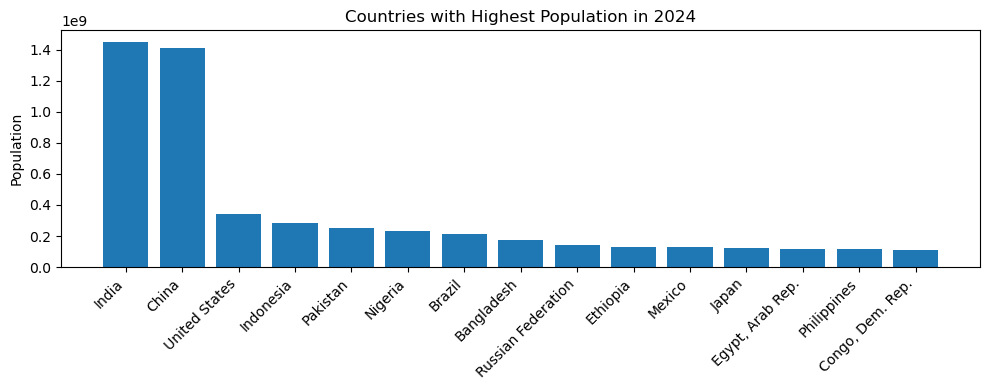

In [143]:
#Now, we will visualize the 15 countries with the highest population in 2024
top15 = df_j_x_merge.nlargest(15, pop_col)

plt.figure(figsize=(10,4))
plt.bar(top15['Geography'], top15[pop_col])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Population')
plt.title('Countries with Highest Population in 2024')
plt.tight_layout()
plt.show()

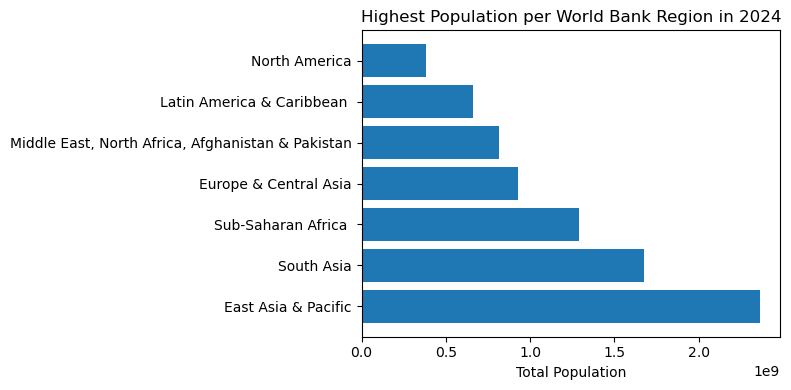

In [145]:
#Now, we will visualize the highest population by World Bank regions in 2024
region_totals = (df_j_x_merge
                 .groupby('Region_JSON', dropna=False)[pop_col]
                 .sum()
                 .sort_values(ascending=False))

plt.figure(figsize=(8,4))
plt.barh(region_totals.index, region_totals.values)
plt.xlabel('Total Population')
plt.title('Highest Population per World Bank Region in 2024')
plt.tight_layout()
plt.show()

# 5. Examine data quality by addressing missing values, outliers, and inconsistencies.

#### Here we examine the titanic dataset from Kaggle which has missing values, inconsistencies, and outliers. 

In [214]:
import os
import pandas as pd
import numpy as np
import plotly.express as px

file_path = os.path.expanduser('~/Desktop/titanic_test.csv')

df_titan = pd.read_csv(file_path)

#Now, we will examine for any missing valuews
missing = df_titan.isnull().sum()
pct_missing = df_titan.isnull().mean() * 100
missing_df = (
    pd.DataFrame({'missing': missing, 'pct_missing': pct_missing})
      .reset_index()
      .rename(columns={'index': 'column'})
      .sort_values('pct_missing', ascending=False)
)
print('Missing values by column:')
print(missing_df)

Missing values by column:
         column  missing  pct_missing
10        Cabin      327    78.229665
5           Age       86    20.574163
9          Fare        1     0.239234
0   PassengerId        0     0.000000
1      Survived        0     0.000000
2        Pclass        0     0.000000
3          Name        0     0.000000
4           Sex        0     0.000000
6         SibSp        0     0.000000
7         Parch        0     0.000000
8        Ticket        0     0.000000
11     Embarked        0     0.000000


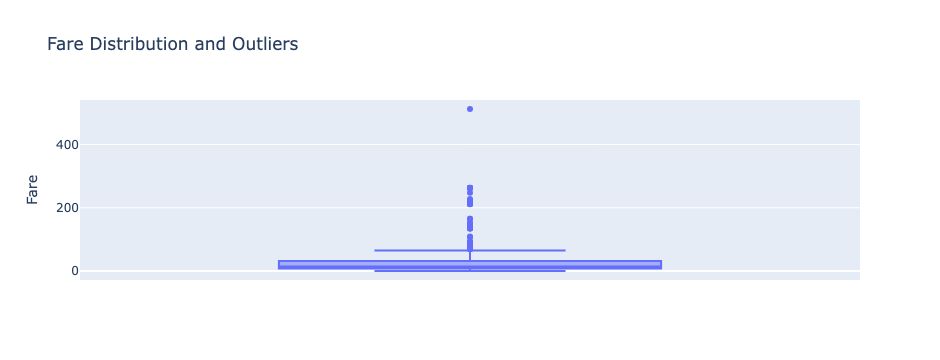

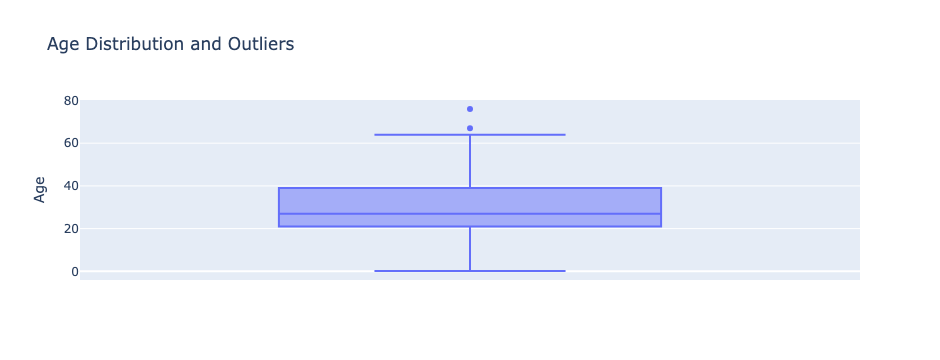

In [216]:
#Now, we'll visualize the outliers and look at fare distribution
for col in ['Fare', 'Age']:
    outliers_fig = px.box(df_titan, y=col, title=f'{col} Distribution and Outliers')
    outliers_fig.show()

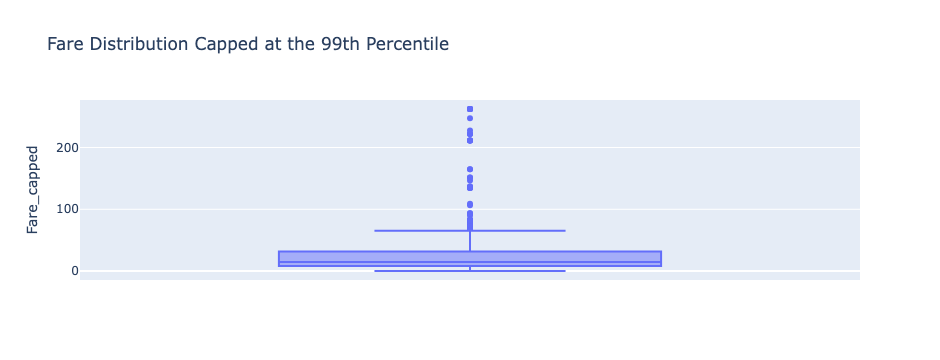

In [218]:
#Here, we will focus on capping extreme values

#We'll examine which are the outliers
fare_cap = df_titan['Fare'].quantile(0.99)

#Now, we will have a cap
df_titan['Fare_capped'] = df_titan['Fare'].clip(upper=fare_cap)

#Visualizing 
cap_fig = px.box(df_titan, y='Fare_capped', title='Fare Distribution Capped at the 99th Percentile')
cap_fig.show()

In [220]:
#Now we will examine the categorical fields for inconsistencies
for col in ['Embarked', 'Cabin', 'Name']:
    counts = df_titan[col].value_counts(dropna=False)
    print(f"\nValue counts for {col}:")
    print(counts.head(10))


Value counts for Embarked:
Embarked
S    270
C    102
Q     46
Name: count, dtype: int64

Value counts for Cabin:
Cabin
NaN                327
B57 B59 B63 B66      3
C89                  2
C116                 2
C80                  2
C55 C57              2
C101                 2
A34                  2
C23 C25 C27          2
C31                  2
Name: count, dtype: int64

Value counts for Name:
Name
Kelly, Mr. James                  1
Carr, Miss. Jeannie               1
Dennis, Mr. William               1
Rosblom, Miss. Salli Helena       1
Touma, Miss. Maria Youssef        1
Fleming, Miss. Honora             1
Peacock, Master. Alfred Edward    1
Oreskovic, Miss. Jelka            1
Oxenham, Mr. Percy Thomas         1
Ware, Mr. John James              1
Name: count, dtype: int64


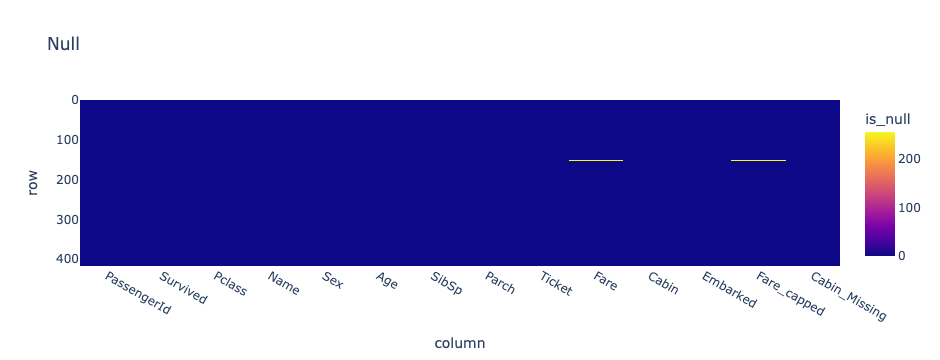

In [232]:
#Creating a heatmap to visualize null values
null_fig = px.imshow(
    df_titan.isnull(),
    labels={'x':'column','y':'row','color':'is_null'},
    title='Null'
)
null_fig.show()

In [234]:
#Now, we will explore the inconsistencies

#Exploring the unique values
print("Embarked values:", df_titan['Embarked'].unique())
print("Sex values:", df_titan['Sex'].unique())
print("Cabin samples", df_titan['Cabin'].dropna().unique()[:10])

Embarked values: ['Q' 'S' 'C']
Sex values: ['male' 'female']
Cabin samples ['Unknown' 'B45' 'E31' 'B57 B59 B63 B66' 'B36' 'A21' 'C78' 'D34' 'D19'
 'A9']


In [250]:
#Standardizing and fixing typos, also confirming the fix

df_titan['Embarked'] = df_titan['Embarked'].str.strip().str.upper()
df_titan['Sex'] = df_titan['Sex'].str.strip().str.lower()
df_titan['Cabin'] = df_titan['Cabin'].str.strip().str.upper()

print("Post-clean Embarked:", df_titan['Embarked'].unique())
print("Post-clean Sex:", df_titan['Sex'].unique())

Post-clean Embarked: ['Q' 'S' 'C']
Post-clean Sex: ['male' 'female']


In [256]:
#Computing summary stats
median_age = df_titan['Age'].median()
mode_embarked = df_titan['Embarked'].mode()[0]
median_fare = df_titan['Fare'].median()

#Filling in any missing values
df_titan['Age'] = df_titan['Age'].fillna(median_age)
df_titan['Embarked'] = df_titan['Embarked'].fillna(mode_embarked)
df_titan['Fare'] = df_titan['Fare'].fillna(median_fare)
df_titan['Cabin_Missing'] = df_titan['Cabin'].isna().astype(int)
df_titan['Cabin'] = df_titan['Cabin'].fillna('Unknown')

#Here, we recompute the capped after filling in the values
fare_cap = df_titan['Fare'].quantile(0.99)
df_titan['Fare_capped'] = df_titan['Fare'].clip(upper=fare_cap)

#Verifying no nulls
print(df_titan[['Age', 'Embarked', 'Fare', 'Cabin']].isna().sum())

Age         0
Embarked    0
Fare        0
Cabin       0
dtype: int64


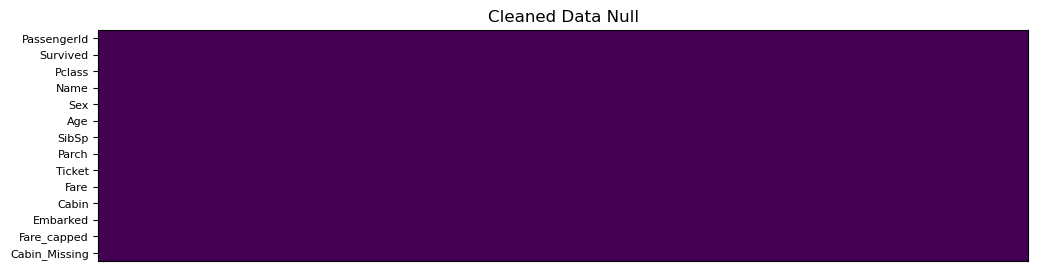

Series([], dtype: int64)


In [258]:
#Visualization of the cleaning
import matplotlib.pyplot as plt

plt.figure(figsize=(12,3))
plt.imshow(df_titan.isnull().T, aspect='auto', interpolation='nearest', cmap='viridis')
plt.yticks(range(len(df_titan.columns)), df_titan.columns, fontsize=8)
plt.xticks([])
plt.title('Cleaned Data Null')
plt.show()

print(df_titan.isnull().sum()[df_titan.isnull().sum() > 0])

# 6. Identify distinguishing characteristics between clean data and unclean data

#### Here, we look at clean and uncleaned data. For instance, any discrepancies, missing values, or irrelevant features are part of uncleaned data. Once cleaned, it is manipulated, and we use it to explore the best model, which in our case is RF.

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df_mpg = pd.read_csv('~/Desktop/auto-mpg+3.csv')
print(df_mpg.isnull().sum())

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64


In [179]:
df_mpg.drop(columns=['origin'], inplace=True, errors='ignore')

In [181]:
#Here, we convert horsepower to numeric
df_mpg['horsepower'] = pd.to_numeric(df_mpg['horsepower'], errors='coerce')

#Now, we compute and fill in the median for any missing values
median_hp = df_mpg['horsepower'].median()
df_mpg['horsepower'] = df_mpg['horsepower'].fillna(median_hp)

#Verifying our edits 
print("Horsepower dtype:", df_mpg['horsepower'].dtype)
print("Missing horsepower after cleaning:", df_mpg['horsepower'].isna().sum())

Horsepower dtype: float64
Missing horsepower after cleaning: 0


In [183]:
#We normalize the column names by replacing . with _
df_mpg.columns = df_mpg.columns.str.replace(' ', '_')

#Verifying the change 
print("Columns after normalization:", df_mpg.columns.tolist())


df_mpg['model_year'] = df_mpg['model_year'].astype(int)

# Dropping the car name column
df_mpg.drop(columns=['car_name'], inplace=True, errors='ignore')

#Dropping any duplicates and resetting the index
df_mpg = df_mpg.drop_duplicates().reset_index(drop=True)

#Checking our edits again
print(df_mpg.info())
print("\nRemaining missing values:\n", df_mpg.isnull().sum())

Columns after normalization: ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'car_name']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 21.9 KB
None

Remaining missing values:
 mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model_year      0
dtype: int64


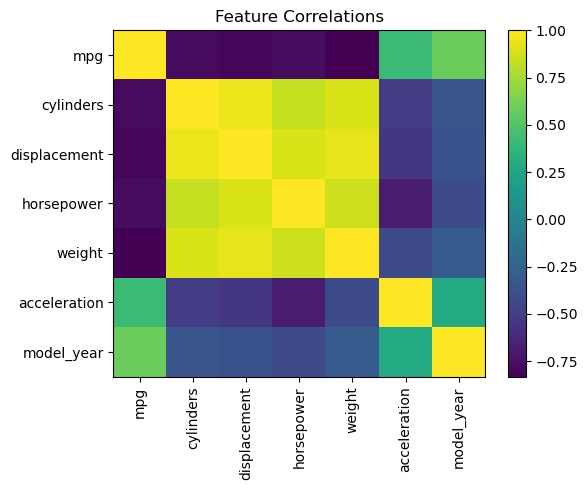

In [185]:
#Creating some visuals of the feature correlations 
corr = df_mpg.corr().values
labels = df_mpg.corr().columns

fig, ax = plt.subplots(figsize=(6,5))
cax = ax.imshow(corr, aspect='auto')
fig.colorbar(cax, ax=ax)
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_yticklabels(labels)
ax.set_title('Feature Correlations')
plt.tight_layout()
plt.show() 

In [232]:
#Now, we will make a simple ML algorithm 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import PartialDependenceDisplay
import pandas as pd


#Defining features and labels 
features = ['cylinders','displacement','horsepower','weight','acceleration','model_year']
X = df_mpg[features]
y = df_mpg['mpg']

#Here we have our train test split at 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#Using a linear regression model first 
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

#Evaluating performance 
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2   = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.3f}")
print(f"Test R²:   {r2:.3f}\n")

#Inspecting coefficients 
coef_df = pd.DataFrame({
    'feature': features,
    'coefficient': lr.coef_
})
print(coef_df.sort_values(by='coefficient', key=abs, ascending=False))

Test RMSE: 3.072
Test R²:   0.824

        feature  coefficient
5    model_year     0.801365
4  acceleration     0.080614
0     cylinders     0.069049
3        weight    -0.007044
2    horsepower     0.002898
1  displacement     0.001604


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [205]:
#Looking at cross-validation scores. We split our data into 5 k folds.
from sklearn.model_selection import cross_val_score
scores = cross_val_score(LinearRegression(), X, y, cv=5, scoring='r2')
print('5 fold CV R^2:', scores.mean())

5 fold CV R^2: 0.5736462891970832


In [207]:
#Fitting only the training fold and scaling features
pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('ridge', RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5))
])

scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
print('Ridge CV R^2:', scores.mean())

Ridge CV R^2: 0.569849092251075


In [217]:
#Standardizing features and tuning the Lasso penalty with 5 fold cross validation
pipe_lasso = Pipeline([
    ('scale', StandardScaler()),
    ('lasso', LassoCV(alphas=[0.01, 0.1, 1, 10], cv=5, random_state=42))
])

scores = cross_val_score(pipe_lasso, X, y, cv=5, scoring='r2')
print('Lasso CV alpha R^2:', scores.mean(), '+/-', scores.std())

pipe_lasso.fit(X, y)
best_alpha = pipe_lasso.named_steps['lasso'].alpha_
print("Selected alpha:", best_alpha)

Lasso CV alpha R^2: 0.5799544443764928 +/- 0.24605460643379656
Selected alpha: 0.1


In [230]:
#Since the previous model did not perform as well, we are now exploring rf and gradient boost 
for Model in (RandomForestRegressor, GradientBoostingRegressor):
    rf = Model(n_estimators=200, random_state=42)
    score = cross_val_score(m, X, y, cv=5, scoring='r2').mean()
    print(f'{Model.__name__} CV R^2:', round(score,3))

RandomForestRegressor CV R^2: 0.746
GradientBoostingRegressor CV R^2: 0.746


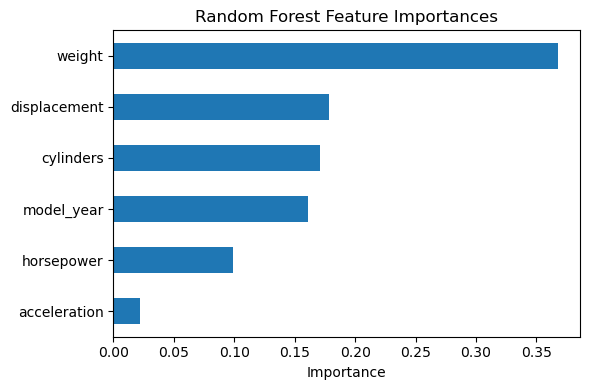

weight          0.367607
displacement    0.178751
cylinders       0.171189
model_year      0.160941
horsepower      0.099153
acceleration    0.022358
dtype: float64


In [234]:
#Since rf was our best performing model
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)

#Visualizing feature importances
importances.sort_values().plot(kind='barh', figsize=(6,4))
plt.xlabel("Importance"); plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

print(importances)

In [238]:
#Here, we are hyperparameter tuning using randomizedsearch
param_dist = {
    'n_estimators':[100, 200, 500],
    'max_depth':[None, 5, 10, 20],
    'max_features':['auto','sqrt','log2'],
    'min_samples_split':[2, 5, 10],
    'min_samples_leaf':[1, 2, 4]
}

rs = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)
rs.fit(X_train, y_train)

best_rf = rs.best_estimator_
print('Best RF params:', rs.best_params_)
print('Best CV R^2:', rs.best_score_)

#Evaluation on test
y_pred = best_rf.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
print('Test‑set R^2:', test_r2)

Best RF params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10}
Best CV R²:    0.8543094359452716
Test‑set R²:   0.9060209846611339


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
40 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
17 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.12/site-pac

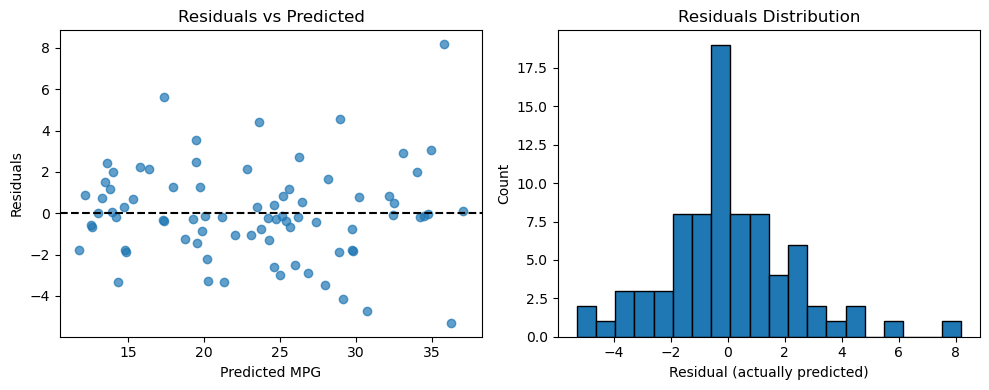

In [246]:
#Now, we will do some residual analysis and plot
residuals = y_test - y_pred

fig, ax = plt.subplots(1,2, figsize=(10,4))

#Residuals vs predicted
ax[0].scatter(y_pred, residuals, alpha=0.7)
ax[0].axhline(0, color='k', linestyle='--')
ax[0].set_xlabel('Predicted MPG')
ax[0].set_ylabel('Residuals')
ax[0].set_title('Residuals vs Predicted')

#Residuals distribution
ax[1].hist(residuals, bins=20, edgecolor='k')
ax[1].set_title('Residuals Distribution')
ax[1].set_xlabel('Residual (actually predicted)')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

###### Residuals look random around zero and have no clear pattern (with the distribution being more or less symmetric). This is positive and indicates that no model assumptions are violated (such as bias). Notably, there are some outliers.

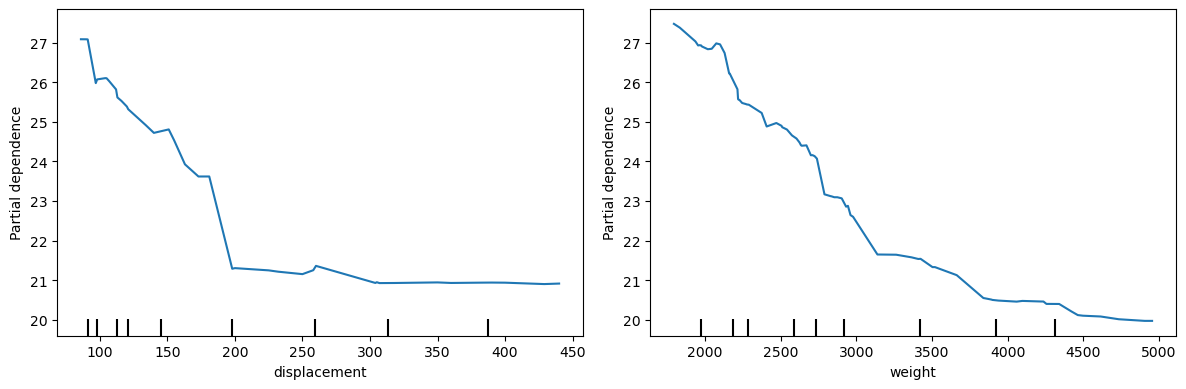

In [242]:
#Now, we will make some partial dependence plots
#Picking the two most important features
importances = pd.Series(best_rf.feature_importances_, index=features)
top2 = importances.sort_values(ascending=False).index[:2].tolist()

fig, ax = plt.subplots(1,2, figsize=(12,4))
PartialDependenceDisplay.from_estimator(
    best_rf, X_test, features=top2, 
    kind='average', ax=ax
)
plt.tight_layout()
plt.show()

##### Here we can see the predicted mpg drops as displacement and weight increase. 

# 7. Identify and correct errors in data, such as typos, incorrect entries, or inconsistencies.

#### Here we look at planetary data and explore missing values and inconsistencies. 

In [152]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df_planets = sns.load_dataset('planets')

#Looking at null values
print(df_planets.isnull().sum())

#Flagging any missing 
df_planets['had_missing'] = df.isnull().any(axis=1)

#Summarizing the numeric columns by the flag
num_cols = df_planets.select_dtypes(include='number').columns
summary = df_planets.groupby('had_missing')[num_cols] \
            .agg(['mean','median','count']) \
            .round(2)
print(summary)

method              0
number              0
orbital_period     43
mass              522
distance          227
year                0
dtype: int64
            number              orbital_period                mass         \
              mean median count           mean  median count  mean median   
had_missing                                                                 
False         1.75    1.0   181         831.60  133.71   173  2.30   1.06   
True          1.60    1.0   115        3818.98  173.78   108  3.19   1.50   

                  distance                  year                
            count     mean median count     mean  median count  
had_missing                                                     
False         110   152.44  46.84   173  2008.57  2010.0   181  
True           73    92.39  43.56   104  2008.05  2009.0   115  


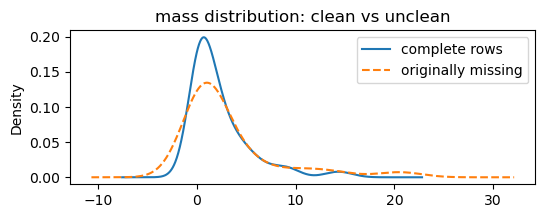

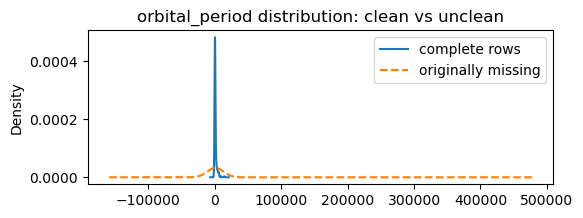

In [156]:
#Visualizing to compare key features
for col in ['mass','orbital_period']:
    plt.figure(figsize=(6,2))
    clean = df_planets[df_planets['had_missing']==False][col]
    dirty = df_planets[df_planets['had_missing']==True][col]
    clean.plot(kind='kde', label='complete rows')
    dirty.plot(kind='kde', label='originally missing', linestyle='--')
    plt.title(f'{col} distribution: clean vs unclean')
    plt.legend()
    plt.show()

In [158]:
#Now, we will fill the missing values with the median
for col in ['orbital_period', 'mass', 'distance']:
    med = df_planets[col].median()
    df_planets[col] = df_planets[col].fillna(med)

#Editing data types 
df_planets['method'] = df_planets['method'].astype('category')
df_planets['number'] = df_planets['number'].astype(int)
df_planets['year'] = df_planets['year'].astype(int)

#Now that we have filled the missing columns, we dropped the flagged columns
df_planets.drop(columns=['had_missing'], inplace=True, errors='ignore')

print("Nulls after cleaning:\n", df_planets.isnull().sum())
print("\nData types:\n", df_planets.dtypes)

Nulls after cleaning:
 method            0
number            0
orbital_period    0
mass              0
distance          0
year              0
dtype: int64

Data types:
 method            category
number               int64
orbital_period     float64
mass               float64
distance           float64
year                 int64
dtype: object


In [160]:
print(df_planets.head())

            method  number  orbital_period   mass  distance  year
0  Radial Velocity       1         269.300   7.10     77.40  2006
1  Radial Velocity       1         874.774   2.21     56.95  2008
2  Radial Velocity       1         763.000   2.60     19.84  2011
3  Radial Velocity       1         326.030  19.40    110.62  2007
4  Radial Velocity       1         516.220  10.50    119.47  2009


In [168]:
#Final summary 
print("Final Numeric Summary:")
print(df_planets[['orbital_period','mass','distance','year']].describe().round(2))

#Printing categorical counts
print("\nDetection methods:")
print(df_planets['method'].value_counts())

Final Numeric Summary:
       orbital_period     mass  distance     year
count         1035.00  1035.00   1035.00  1035.00
mean          1921.37     1.94    218.27  2009.07
std          25471.07     2.77    653.41     3.97
min              0.09     0.00      1.35  1989.00
25%              5.75     1.26     38.01  2007.00
50%             39.98     1.26     55.25  2010.00
75%            487.10     1.26    130.72  2012.00
max         730000.00    25.00   8500.00  2014.00

Detection methods:
method
Radial Velocity                  553
Transit                          397
Imaging                           38
Microlensing                      23
Eclipse Timing Variations          9
Pulsar Timing                      5
Transit Timing Variations          4
Orbital Brightness Modulation      3
Astrometry                         2
Pulsation Timing Variations        1
Name: count, dtype: int64


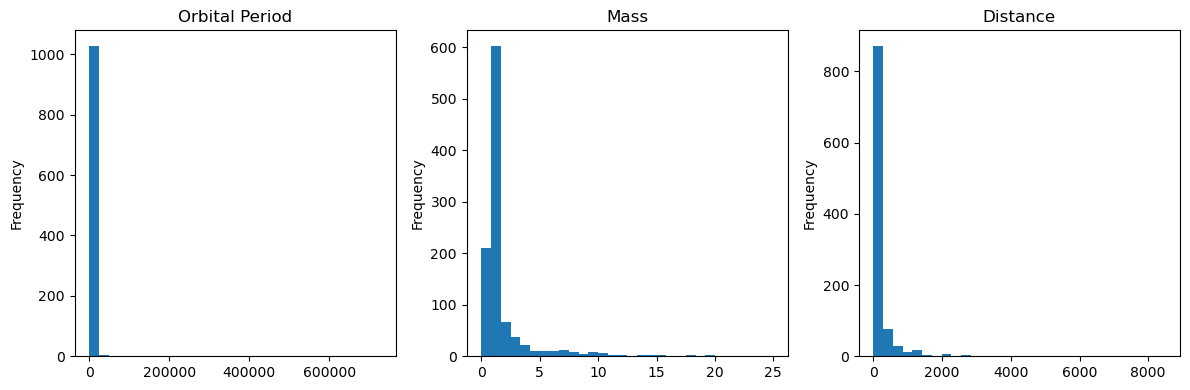

In [170]:
#Visualizing with some distribution plots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
df_planets['orbital_period'].plot(kind='hist', bins=30, ax=axes[0], title='Orbital Period')
df_planets['mass'].plot(kind='hist', bins=30, ax=axes[1], title='Mass')
df_planets['distance'].plot(kind='hist', bins=30, ax=axes[2], title='Distance')
for ax in axes:
    ax.set_xlabel('')
plt.tight_layout()
plt.show()